### Libray Imports

In [0]:
import numpy as np                           # vectors and matrices
import pandas as pd                          # tables and data manipulations
import matplotlib.pyplot as plt              # plots
import seaborn as sns                        # more plots
import math
from dateutil.relativedelta import relativedelta

from scipy.optimize import minimize 
import scipy.stats as scs 

# import statsmodels.formula.api as smf 
# import statsmodels.tsa.api as smt
# import statsmodels.api as sm

from itertools import product
from tqdm import tqdm_notebook 

import warnings                               # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

In [0]:
plt.style.use('seaborn-dark')

In [4]:
!wget https://storage.googleapis.com/columbia_applied_deep_learning/demand_forecasting.zip  \
    -O ./demand_forecasting.zip

--2019-05-19 10:19:37--  https://storage.googleapis.com/columbia_applied_deep_learning/demand_forecasting.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3361698 (3.2M) [application/zip]
Saving to: ‘./demand_forecasting.zip’

./demand_forecastin 100%[===================>]   3.21M  --.-KB/s    in 0.02s   

2019-05-19 10:19:37 (163 MB/s) - ‘./demand_forecasting.zip’ saved [3361698/3361698]



In [0]:
import zipfile
local_zip = './demand_forecasting.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [6]:
!ls -al

total 7284
drwxr-xr-x 1 root root    4096 May 19 10:19 .
drwxr-xr-x 1 root root    4096 May 19 09:50 ..
drwxr-xr-x 1 root root    4096 May 16 16:08 .config
-rw-r--r-- 1 root root 3361698 May 19 03:13 demand_forecasting.zip
drwxr-xr-x 2 root root    4096 May 19 10:19 __MACOSX
-rw-r--r-- 1 root root  189008 May 19 10:19 model1_eu.hdf5
-rw-r--r-- 1 root root  188968 May 19 10:19 model1_id2.hdf5
-rw-r--r-- 1 root root  171048 May 19 10:19 model1_th.hdf5
-rw-r--r-- 1 root root  901416 May 19 10:19 model2_eu.hdf5
-rw-r--r-- 1 root root  901312 May 19 10:19 model2_id2.hdf5
-rw-r--r-- 1 root root  901312 May 19 10:19 model2_th.hdf5
-rw-r--r-- 1 root root  150744 May 19 10:19 model3_eu.hdf5
-rw-r--r-- 1 root root  150744 May 19 10:19 model3_id2.hdf5
-rw-r--r-- 1 root root  150744 May 19 10:19 model3_th_exp_120.hdf5
-rw-r--r-- 1 root root  150744 May 19 10:19 model3_th_exp.hdf5
-rw-r--r-- 1 root root  142760 May 19 10:19 model3_th.hdf5
-rw-r--r-- 1 root root    8090 May 19 10:19 Product1-Dataset

### Data Ingestion and Plotting

We are modelling sales date in this notebook

In [0]:
checkpoint_dir = './'
data_filename = 'Product1-Dataset-th-1year.csv'

In [0]:
time_series = pd.read_csv(data_filename, header=0, parse_dates=[0], index_col=0, squeeze=True)

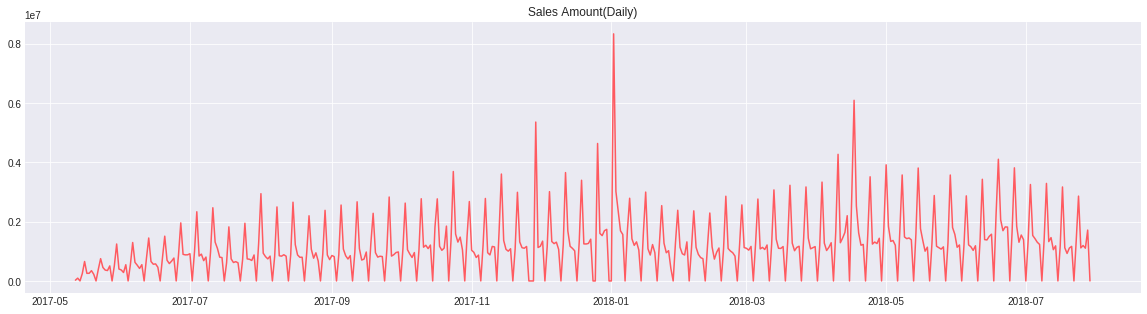

In [10]:
fig, ax = plt.subplots(1,1, figsize= (20,5))
ax.plot(time_series, color='#FF5A60')
ax.set_title(f"Sales Amount(Daily)")
ax.grid(True)
sns.despine()

### Forecast Quality Metrics

---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

> $MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

> $MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Root Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): It is just the square root of Mean Squared Error

> $RMSE = \sqrt{\frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2}$

```python
sklearn.metrics.mean_squared_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

> $MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [0]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_pred, y_true): 
  return np.mean(np.abs((y_pred - y_true) / y_pred)) * 100
  
def rmse(y_pred, y_true):
  return math.sqrt(mean_squared_error(y_pred, y_true))

Now that we know how to measure the quality of the forecasts, let's see what metrics we can use and how to translate the results. After that, one small detail remains - building the model.

### Move, Smooth, Evaluate

Let's start with a naive hypothesis: ```"tomorrow will be the same as today"```. However, instead of a model like $\hat{y}_{t} = y_{t-1}$ (which is actually a great baseline for any time series prediction problems and sometimes is impossible to beat), we will assume that the future value of our variable depends on the average of its k previous values. Therefore, we will use the moving average.

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k}_{n=1} y_{t-n}$

In [0]:
def moving_average(series, n):
    """
    Calculate average of last n items
    """
    return np.average(series[-n:])

In [13]:
moving_average(time_series, 7) # prediction for the next day based on last 7 days

1335964.18

Unfortunately, we cannot make predictions far in the future -- in order to get the value for the next step, we need the previous values to be actually observed. But moving average has another use case - smoothing the original time series to identify trends. Pandas has an implementation available with ```DataFrame.rolling(window).mean()```. The wider the window, the smoother the trend. In the case of very noisy data, which is often encountered in data, this procedure can help detect common patterns.

In [0]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

Let's Smooth by previous 1 day

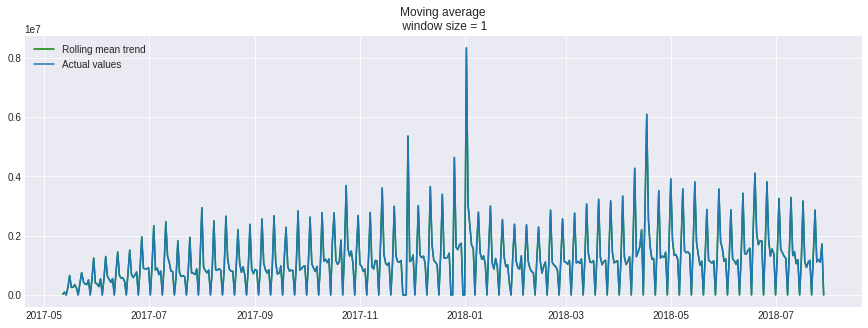

In [15]:
plotMovingAverage(time_series, 1)

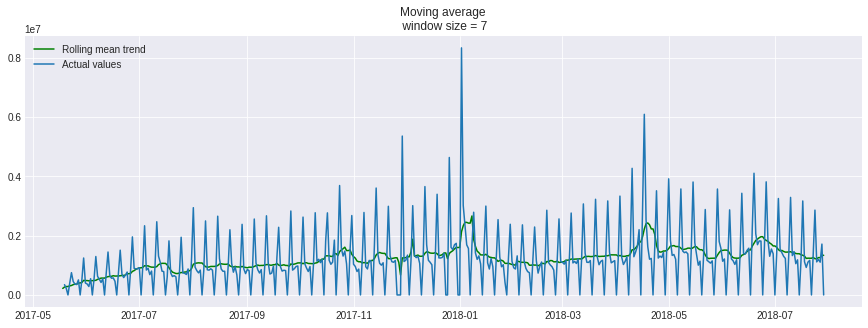

In [16]:
plotMovingAverage(time_series, 7)

Now Let's try smoothing by the previous 2 weeks

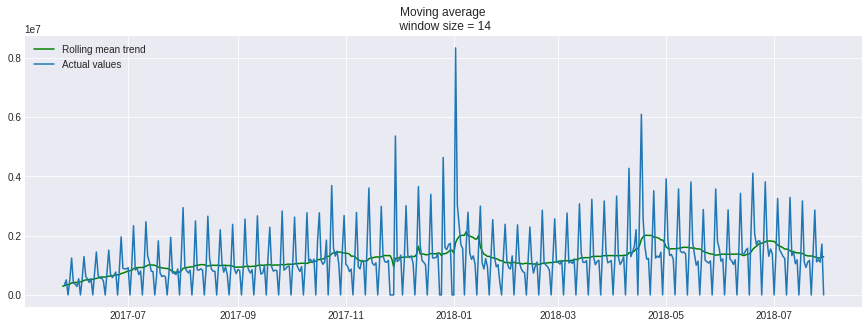

In [17]:
plotMovingAverage(time_series, 14)

Now with the previous month, we get the monthly trend.

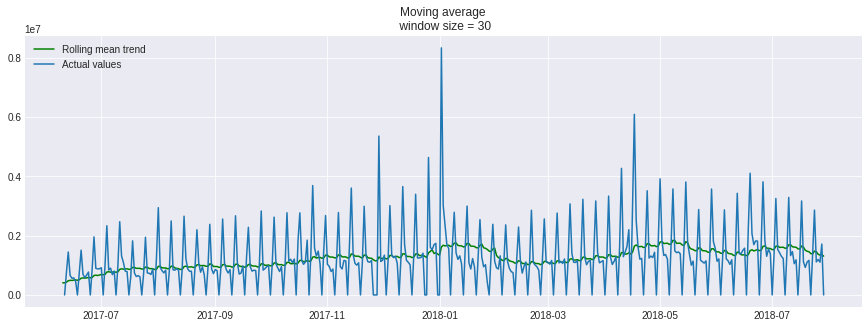

In [18]:
plotMovingAverage(time_series, 30)

When we applied daily smoothing on daily data, we could clearly see the dynamics of Sales. 

We can also plot confidence intervals for our smoothed values.



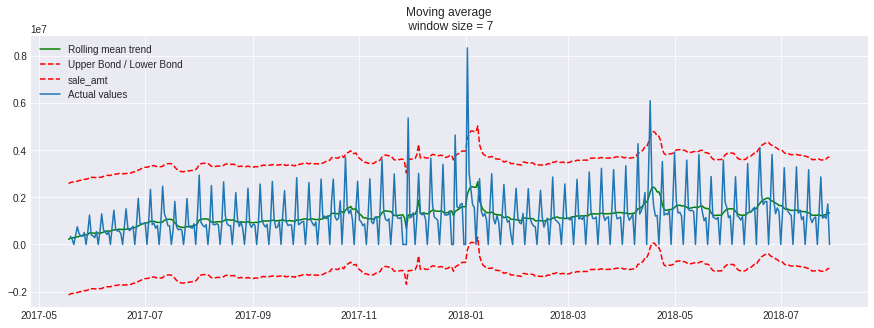

In [19]:
plotMovingAverage(time_series, 7, plot_intervals=True)

### Linear models on time series

Very often it's much easier to select a few features from the existing time series and build a simple linear regression model or, say, a random forest. It is good and cheap.

This approach is not backed by theory and breaks several assumptions (e.g. Gauss-Markov theorem, especially for errors being uncorrelated), but it is very useful in practice and is often used in machine learning competitions.

##### Feature exctraction

The model needs features, and all we have is a 1-dimentional time series. What features can we exctract? 
* Lags of time series
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Date and time features:
    - Minute of an hour, hour of a day, day of the week, and so on
    - Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
* Target encoding 
* Forecasts from other models (note that we can lose the speed of prediction this way)

Let's run through some of the methods and see what we can extract from our sales time series data.

##### Lags of time series

Shifting the series n steps back, we get a feature column where the current value of time series is aligned with its value at time t−n. If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.

In [0]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(time_series.copy())
data.columns = ["y"]

In [0]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(1, 8):
    data["lag_{}".format(i)] = data.y.shift(i)

In [22]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
2018-07-23,1367183.28,0.00,1165755.83,1107539.37,926864.89,1117313.97,3167044.61,1171181.17
2018-07-24,2858611.48,1367183.28,0.00,1165755.83,1107539.37,926864.89,1117313.97,3167044.61
2018-07-25,1113746.92,2858611.48,1367183.28,0.00,1165755.83,1107539.37,926864.89,1117313.97
2018-07-26,1194197.42,1113746.92,2858611.48,1367183.28,0.00,1165755.83,1107539.37,926864.89
2018-07-27,1104005.60,1194197.42,1113746.92,2858611.48,1367183.28,0.00,1165755.83,1107539.37
2018-07-28,1714004.56,1104005.60,1194197.42,1113746.92,2858611.48,1367183.28,0.00,1165755.83
2018-07-29,0.00,1714004.56,1104005.60,1194197.42,1113746.92,2858611.48,1367183.28,0.00


Great, we have generated a dataset here. Let's train a model

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [0]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [0]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.1)

In [28]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    rmse_err = rmse(prediction,y_test)
#     print (error, rmse_err)
    plt.title("Mean absolute percentage error - {0:.2f}%".format(error) + ";  RMSE - {0:.2f}".format(rmse_err))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

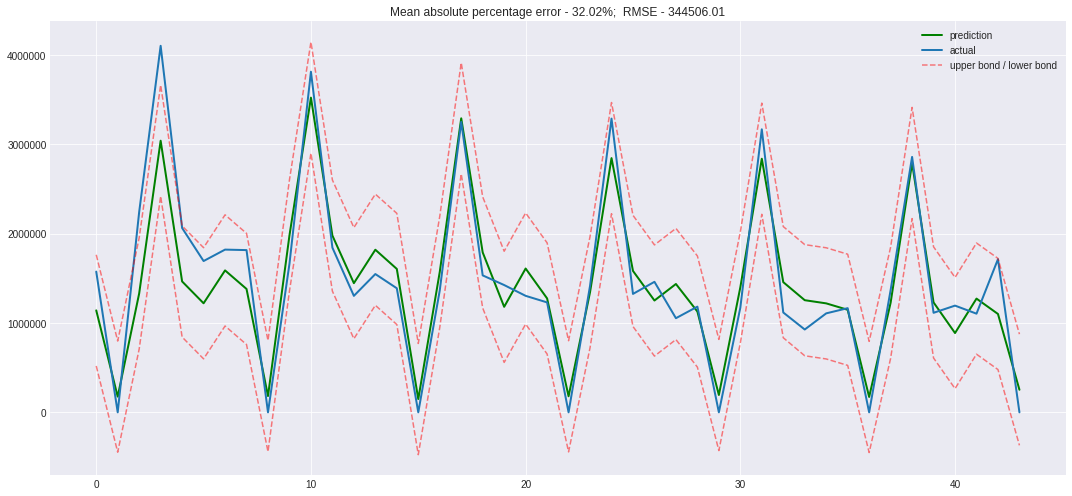

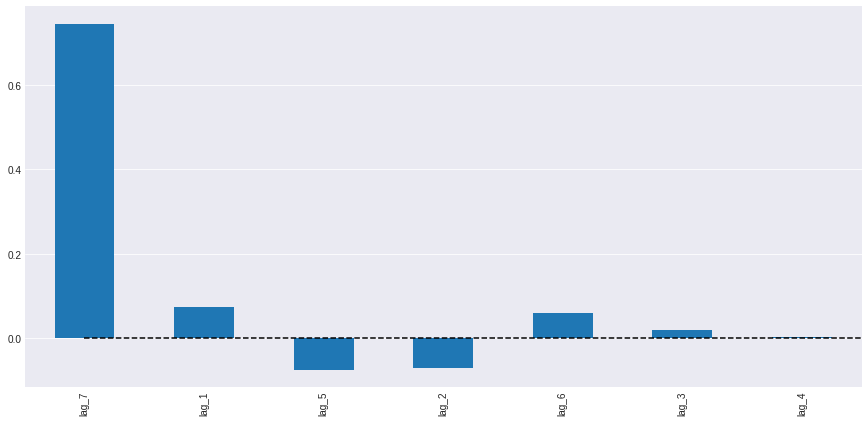

In [30]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

We'll add ```hour```, ```day of week```, and a boolean for ```is_weekend```. To do so, we need to transform the current dataframe index into the datetime format and extract hour and weekday

In [31]:
data.index.to_pydatetime()

array([datetime.datetime(2017, 5, 12, 0, 0),
       datetime.datetime(2017, 5, 13, 0, 0),
       datetime.datetime(2017, 5, 14, 0, 0),
       datetime.datetime(2017, 5, 15, 0, 0),
       datetime.datetime(2017, 5, 16, 0, 0),
       datetime.datetime(2017, 5, 17, 0, 0),
       datetime.datetime(2017, 5, 18, 0, 0),
       datetime.datetime(2017, 5, 19, 0, 0),
       datetime.datetime(2017, 5, 20, 0, 0),
       datetime.datetime(2017, 5, 21, 0, 0),
       datetime.datetime(2017, 5, 22, 0, 0),
       datetime.datetime(2017, 5, 23, 0, 0),
       datetime.datetime(2017, 5, 24, 0, 0),
       datetime.datetime(2017, 5, 25, 0, 0),
       datetime.datetime(2017, 5, 26, 0, 0),
       datetime.datetime(2017, 5, 27, 0, 0),
       datetime.datetime(2017, 5, 28, 0, 0),
       datetime.datetime(2017, 5, 29, 0, 0),
       datetime.datetime(2017, 5, 30, 0, 0),
       datetime.datetime(2017, 5, 31, 0, 0),
       datetime.datetime(2017, 6, 1, 0, 0),
       datetime.datetime(2017, 6, 2, 0, 0),
       datet

In [32]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,weekday,is_weekend
date,,,,,,,,,,
2018-07-25,1113746.92,2858611.48,1367183.28,0.00,1165755.83,1107539.37,926864.89,1117313.97,2,0
2018-07-26,1194197.42,1113746.92,2858611.48,1367183.28,0.00,1165755.83,1107539.37,926864.89,3,0
2018-07-27,1104005.60,1194197.42,1113746.92,2858611.48,1367183.28,0.00,1165755.83,1107539.37,4,0
2018-07-28,1714004.56,1104005.60,1194197.42,1113746.92,2858611.48,1367183.28,0.00,1165755.83,5,1
2018-07-29,0.00,1714004.56,1104005.60,1194197.42,1113746.92,2858611.48,1367183.28,0.00,6,1


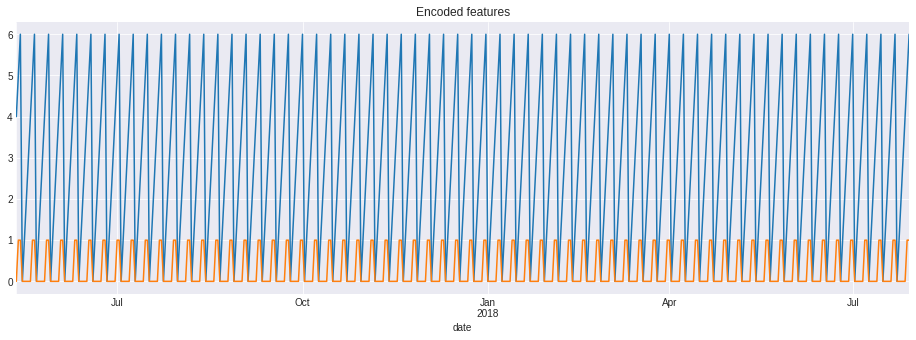

In [33]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
#data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Since we now have different scales in our variables, thousands for the lag features and tens for categorical, we need to transform them into same scale for exploring feature importance and, later, regularization.

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

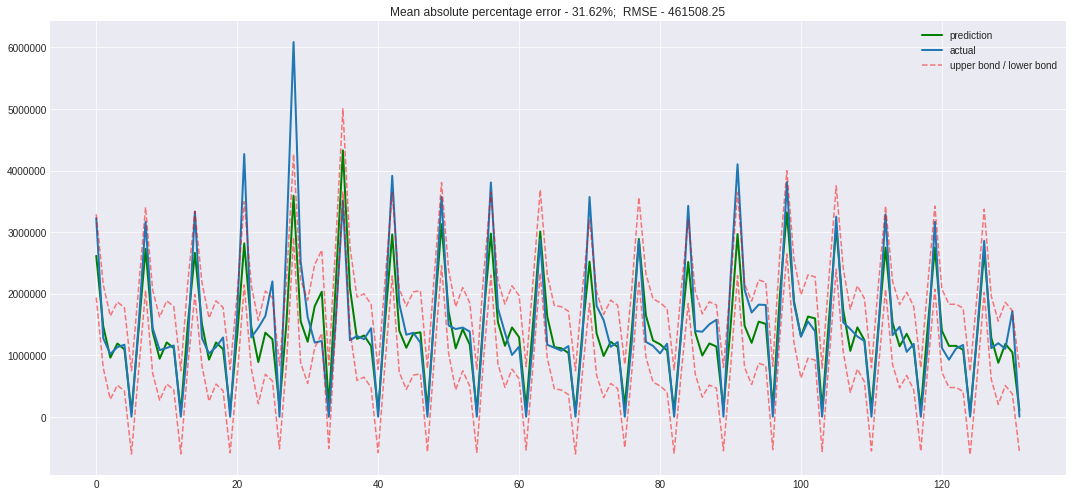

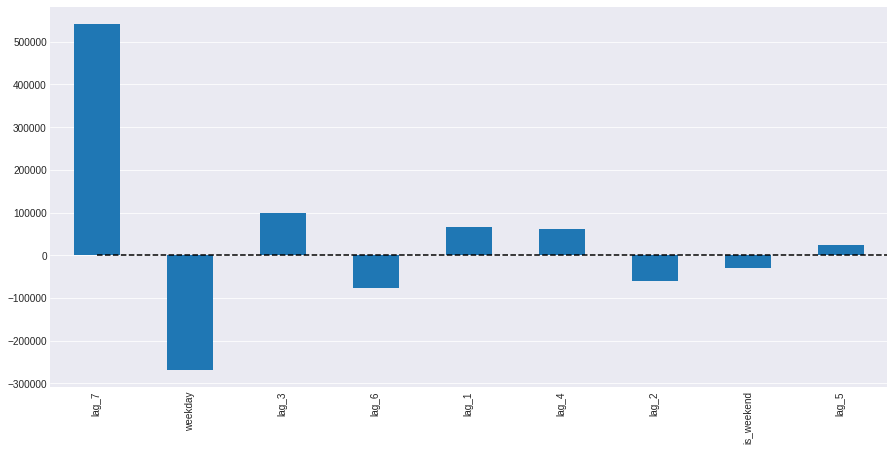

In [35]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

The test error goes down a little bit. Judging by the coefficients plot, we can say that weekday and is_weekend are useful features.



##### Target encoding

I'd like to add another variant for encoding categorical variables: encoding by mean value.The natural idea is to encode with the mean value of the target variable. In our example, every day of the week and every hour of the day can be encoded by the corresponding average number of sales during that day or hour. It's very important to make sure that the mean value is calculated over the training set only (or over the current cross-validation fold only) so that the model is not aware of the future.

In [0]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Finally, let's put all the transformations together in a single function .

In [0]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    #data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # frop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

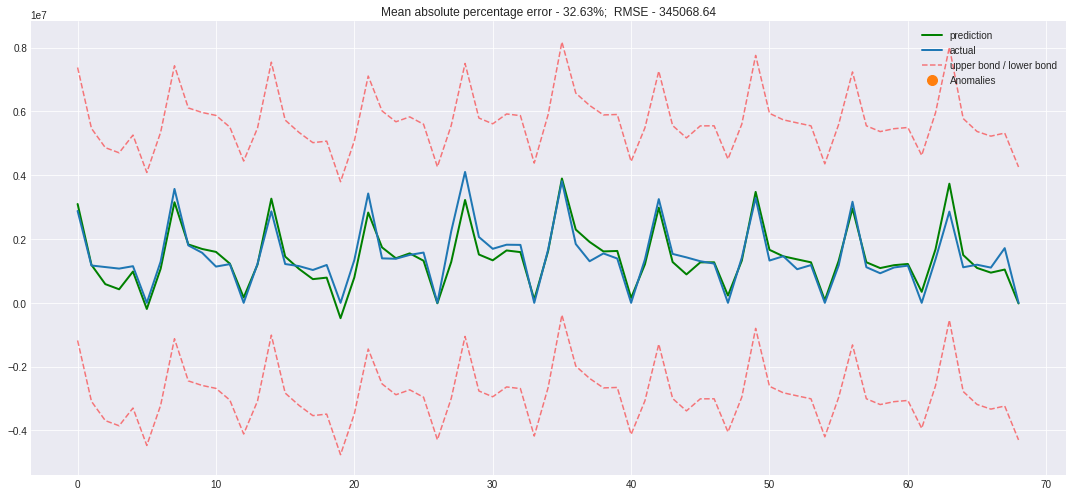

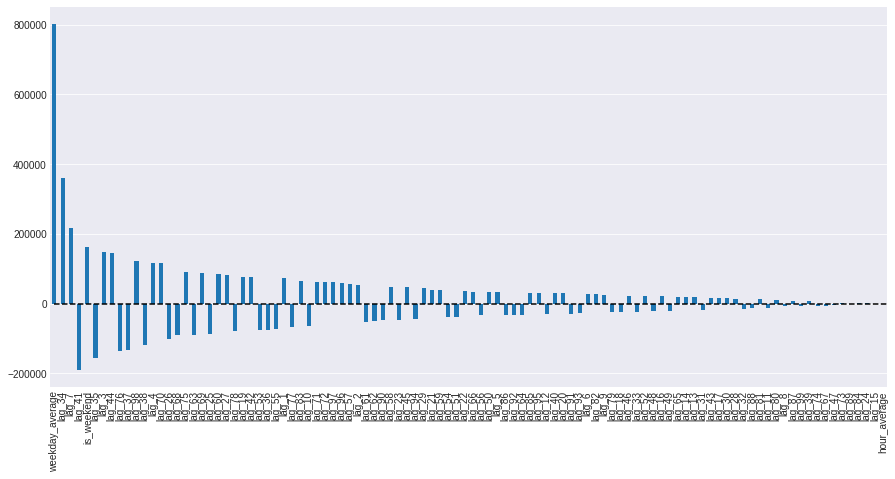

In [38]:
X_train, X_test, y_train, y_test = prepareData(time_series, lag_start=1, lag_end=100, test_size=0.2, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

We see some overfitting! Hour_average was so great in the training dataset that the model decided to concentrate all of its forces on it. As a result, the quality of prediction dropped. This problem can be solved in a variety of ways; for example, we can calculate the target encoding not for the whole train set, but for some window instead. That way, encodings from the last observed window will most likely better describe the current series state. Alternatively, we can just drop it manually since we are sure that it makes things only worse in this case.

In [0]:
X_train, X_test, y_train, y_test =\
prepareData(time_series, lag_start=1, lag_end=7, test_size=0.1, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### Regularization and feature selection

As we already know, not all features are equally healthy -- some may lead to overfitting while others should be removed. Besides manual inspection, we can apply regularization. ```Two of the most popular regression models with regularization are Ridge and Lasso regressions```. They both add some more constrains to our loss function.

In the case of Ridge regression, those constraints are the sum of squares of the coefficients multiplied by the regularization coefficient. The bigger the coefficient a feature has, the bigger our loss will be. Hence, we will try to optimize the model while keeping the coefficients fairly low.

As a result of this L2 regularization, we will have higher bias and lower variance, so the model will generalize better (at least that's what we hope will happen).

The second regression model, Lasso regression, adds to the loss function, not squares, but absolute values of the coefficients. As a result, during the optimization process, coefficients of unimportant features may become zeroes, which allows for automated feature selection. This regularization type is called L1.

First, let's make sure that we have features to drop and that the data has highly correlated features.

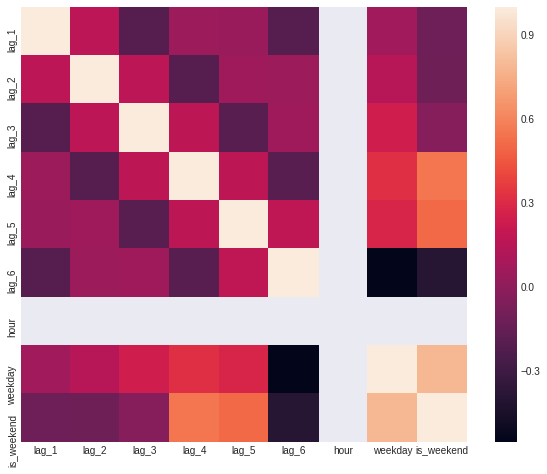

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

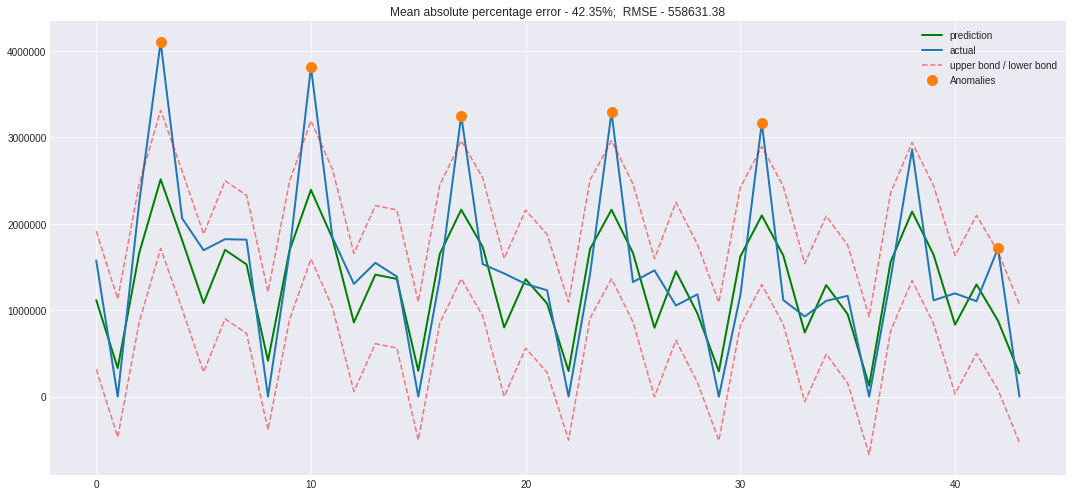

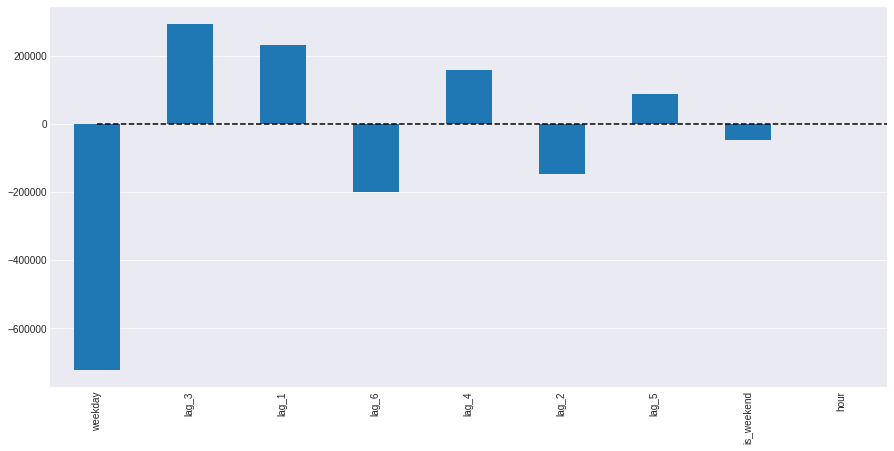

In [41]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

We can clearly see some coefficients are getting closer and closer to zero (though they never actually reach it) as their importance in the model drops.

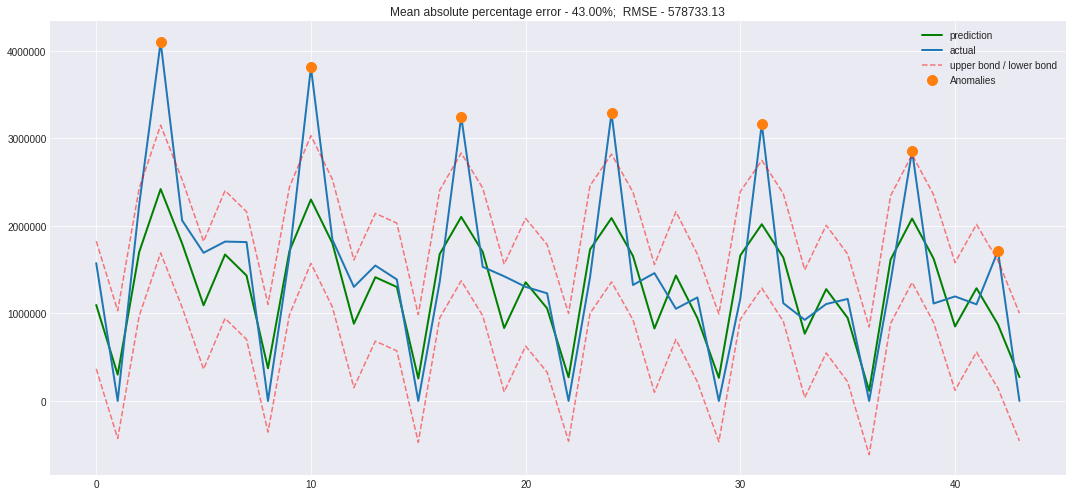

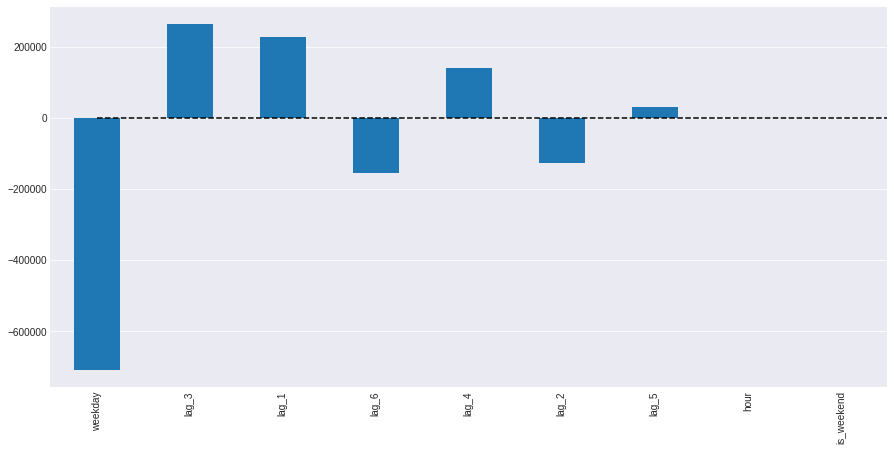

In [42]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Lasso regression turned out to be more conservative; it removed 23-rd lag from the most important features and dropped 5 features completely, which only made the quality of prediction better.

#### Boosting

**Let's try XGBoost now!**

In [43]:
import sys
import xgboost
#sys.path.append('/Users/dmitrys/xgboost/python-package/')
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

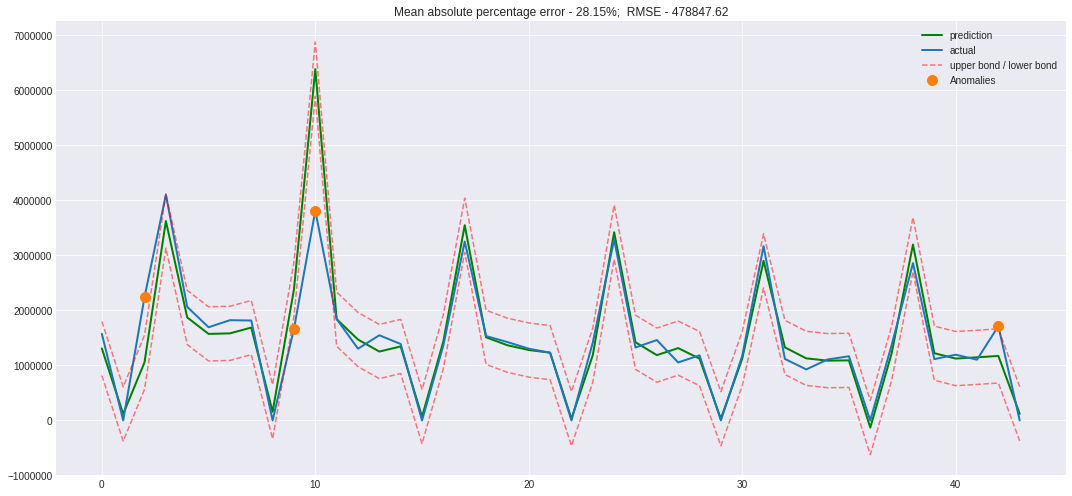

In [45]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

We have a read a lot! This is the smallest error on the test set among all the models we've tried so far.

### Conclusion

We discussed different time series analysis and prediction methods. Unfortunately, or maybe luckily, there is no one way to solve these kind of problems. Methods developed in the 1960s (and some even in the beginning of the 21st century) are still popular, along with LSTMs and RNNs (covered subsequently as part of this Project). In spite of the large number of formal quality metrics and approaches to parameters estimation, it is often necessary to try something different for each time series.